<a href="https://colab.research.google.com/github/xspronken/bigdataW1/blob/master/week3v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTS**

In [0]:
import numpy as np
import math as m
import matplotlib.pyplot as plt

# FUNCTIONS AND VARIABLES

In [0]:
''' For conversion from natural units'''
G = 6.67*10**(-11)    # (m**3)*(kg**-1)*(s**-2)
c = 3*10**8    # m*(s**-1)




####################################### DEFINING VARIABLES #######################################

''' Defining waveform and fourrier transform variables'''
m1 = 10**30 # kg
m2 = 10**30 # kg

M = (m1+m2) # kg
n = m1*m2/(M**2) #dimensionless
M_chirp = n**(3/5)*M # kg
t_c = 100# secs
phi_c = 100 #rads


#alpha coefficients as given by eq 3.4 || note that only alpha 0 to 4 have been inserted, therefore highest PN possible is 2
alpha = [1, 0, (20/9*(743/336 + n*11/4)), -16*m.pi, 10*(3058673/1016064 + n*5429/1008 + (n**2) * 617/144)]
PN = 1 

SNR = 10


''' Defining Power Spectral Density S(f) of Initial Ligo and its variables'''
# as given in the paper eq 3.8

fs = 40 # Hz
f0 = 150 # Hz
s0 = 9**(-46) #Hz**-1

def S(f):
  x = f/f0
  if (f >= fs):
    return s0*((4.49*x)**(-56)+0.16*x**(-4.52)+0.52+0.32*x**2)
  else: 
    return float('inf')


''' defining upper and lower cut-off frequencies''' 
# Limits of  the integrals used to fill in the Fischer information Matrix and calulating A

F_high = (6**(3/2)*m.pi*M*G*(c**-3))**-1 # eq 3.6 || assuming the to constants to be dimensionless and M being in kg we multiply by g*c**-3 to get Hz as a final result
F_low = fs


''' Computing the variable A '''

def compute_A(SNR, dx):
  #perform integral using trapezoidal sums
  accumulator = 0
  for i in range (int(F_low/dx), int(F_high/dx - 1)):
   x = i*dx
   fi = (x**(-7/6) / (S(x)))
   fi2 = ((x + dx)**(-7/6) / (S(x + dx)))
   accumulator += dx * (fi + fi2)/2
  # divide SNR by integral multiplied by 4
  A = m.sqrt(SNR/(4*accumulator))
  
  print ("A = ", A, "\n")
  return A




''' Defining the list of independent parameters processed into the matrix''' 

teta = [t_c, phi_c, M_chirp, n]

''' Defining the Fourrier transform h(f) and it's waveform psi'''

def h(f, A, params, x):
  #defining the waveform's variables with respect to which h(f) will be partially derived 
  #make sure they correspond to the values inserted previously into teta
  
  t_c, phi_c, M_chirp, n = params
  
  M = M_chirp*n**(-3/5)  
  
  v = (m.pi*M*f*G/c**3)**(1/3) # eq. 3.3 || v is dimensionless, M in kg, F in Hz || multiplying by G/c**3 converts to the right units
  
  #sum of all coefficients (alpha) in the fourrier phase
  x *= 2
  sum_alpha = 0
  for i in range(x):
    sum_alpha += (alpha[i] * (v**i))
  
  #defining the waveform psi(f) || this waveform can be modified along with the variables defined previously 
  psi =  2*m.pi*f*t_c - phi_c - m.pi/4 + 3/(128*n*v**5)*sum_alpha

  return  A * f**(-7/6) * m.e**(1j * psi)




####################################### COMPUTATIONS #######################################

''' Calculating the partial derivative of h(f) '''
def h_partial(f, A, params, x):   
  dx = params[x]/100
  dparams = params.copy()
  dparams[x] += dx
  dy = h(f, A, dparams, PN)-h(f, A, params, PN)
  return dy/dx

''' Generating the Fischer information matrix '''
def generate_matrix(A, params, dx):
  
# create a  n*n matrix where n is the number of observables
  n = len(params)
  matrix = np.empty([n,n]) 
  
# Start filling the matrix
  for i in range (n):
    for j in range (n):
      
      #start integration (again with trap sums) using eq 2.11 of the paper as a reference instead of the plug and play
      accumulator = 0
      for k in range(int(F_low/dx), int(F_high/dx-1)):
        x1 = k*dx
        part_i1 = h_partial(x1, A, params,i)
        part_j1 = h_partial(x1, A, params,j)
        f1 = ((part_i1 * np.conj(part_j1))+(np.conj(part_i1) * part_j1))/S(x1)  
        
        x2 = k*dx + dx 
        part_i2 = h_partial(x2, A, params,i)
        part_j2 = h_partial(x2, A, params,j)
        f2 = ((part_i2 * np.conj(part_j2))+(np.conj(part_i2) * part_j2))/S(x2)
        
        accumulator += np.real(dx * (f1 + f2)/2)
      
      #once integration is done add it to the matrix
      matrix[i][j] = accumulator*2
  print("Fischer matrix : \n",  matrix)
  return matrix


''' Extract the diagonal elements from the inverted Fischer matrix'''

def extract_from_matrix(matrix):
  #invert matrix
  y = np.linalg.inv(matrix) 
  z = []
  
  #fetch the square root of diagonal elements
  for i in range (len(y)):
    z.append(m.sqrt(y[i][i]))
  
  return z


####################################### Exercise 3 functions ############################################

def fetch_ligo(nb_col):
  if nb_col > 6 or nb_col < 1:
    print('invalid column number, column number was reset to default (6)')
    nb_col = 6
  data = []
  freq = []
  sens = []
  f = open('LIGO.txt')
  lines = f.readlines()
  for x in range(len(lines)):
    line = list(map(float,lines[x].split()))
    data.append(line)
  for y in range(len(data)):
    freq.append(data[y][0])
    sens.append(data[y][nb_col])
  
  return freq, sens


def fetch_einstein(nb_col):
  if nb_col > 3 or nb_col < 1:
    print('invalid column number, column number was reset to default (3)')
    nb_col = 3
  data = []
  freq = []
  sens = []
  final = []
  f = open('EINSTEIN.txt')
  lines = f.readlines()
  for x in range(len(lines)):
    line = list(map(float,lines[x].split()))
    data.append(line)
  for y in range(len(data)):
    freq.append(data[y][0])
    sens.append(data[y][nb_col])
  
  return freq, sens

  ''' the functions defining A and the fischer matrix are modified to accept data loaded from eintein telescope or ligo '''

def compute_A_2(data, SNR):
  #perform integral using trapezoidal sums
  accumulator = 0
  for x in range(len(data[0])-1) : # possible to do this because data[0] and data[1] ahve the same length
   freq = data[0][x]
   sens = data[1][x]
   fi = (freq**(-7/6) / sens)
  
   freq2 = data[0][x+1]
   sens2 = data[1][x+1]
   fi2 = (freq2**(-7/6) / sens2)
     
   accumulator += (freq2-freq) * (fi + fi2)/2
  
  # divide SNR by integral multiplied by 4
  A = m.sqrt(SNR/(4*accumulator))
  
  print ("A = ", A, "\n")
  return A


def generate_matrix_2(A, params, data):
 
# create a  n*n matrix where n is the number of observables
  n = len(params)
  matrix = np.empty([n,n]) 
  
# Start filling the matrix
  for i in range (n):
    for j in range (n):
      
      #start integration (again with trap sums) using eq 2.11 of the paper as a reference instead of the plug and play
      accumulator = 0
      for k in range(len(data[0])-1):
        freq = data[0][k]
        sens = data[1][k]
        part_i1 = h_partial(freq, A, params,i)
        part_j1 = h_partial(freq, A, params,j)
        f1 = (part_i1*np.conj(part_j1) + np.conj(part_i1)*part_j1)/sens  
        
        freq2 = data[0][k+1]
        sens2 = data[1][k+1]
        part_i2 = h_partial(freq2, A, params,i)
        part_j2 = h_partial(freq2, A, params,j)
        f2 = ((part_i2 * np.conj(part_j2))+(np.conj(part_i2) * part_j2))/sens2
        
        accumulator += np.real((freq2-freq) * (f1 + f2)/2)
      
      #once integration is done add it to the matrix
      matrix[i][j] = accumulator*2
  print("Fischer matrix : \n",  matrix, "\n")
  return matrix

def comparison_plot(diagLigo, diagEinstein):
  y = list(zip(diagLigo, diagEinstein))
  x = ["Ligo", "Einstein"]
  for i in range(len(y)):
    plt.figure()
    plt.title("Parameter %i" %i)
    plt.plot(x, y[i],'o')
    plt.ylabel('Measurability')
    plt.xlabel("Telescope")
    plt.show 
  return None



# EXERCISE 1 / 2

In [23]:
print("teta : t_c, phi_c, M, n: ", teta)
A = compute_A(10, 0.001)  # Inputs are SNR and increment used for integrating with trap sums
fischer = generate_matrix(A, teta, 0.1)
Results = extract_from_matrix(fischer)
print("Results for PN =", PN, " : " ,Results)

teta : t_c, phi_c, M, n:  [100, 100, 2000000000000000000000000000000, 0.25]
A =  2.331029579377938e-22 

Fischer matrix : 
 [[5.65236943e-02 1.29855392e-02 1.43440504e-30 1.14343116e+01]
 [1.29855392e-02 2.59837484e-02 6.50297090e-31 5.21538539e+00]
 [1.43440504e-30 6.50297090e-31 1.41439798e-58 5.63737301e-28]
 [1.14343116e+01 5.21538539e+00 5.63737301e-28 9.07077481e+03]]
Results for PN = 1  :  [5.242343341038053, 6.817949829675521, 1.0434526672746667e+29, 0.013012671068597343]


In [25]:
print("teta : t_c, phi_c, M: ", teta)
A = compute_A(10, 0.001)  # Inputs are SNR and increment used for integrating with trap sums
fischer = generate_matrix(A, teta, 0.1)
Results = extract_from_matrix(fischer)
print("Results for PN =", PN, " : " ,Results)

teta : t_c, phi_c, M:  [100, 100, 2000000000000000000000000000000]
A =  2.331029579377938e-22 

Fischer matrix : 
 [[5.65236943e-02 1.29855392e-02 1.43440504e-30]
 [1.29855392e-02 2.59837484e-02 6.50297090e-31]
 [1.43440504e-30 6.50297090e-31 1.41439798e-58]]
Results for PN = 1  :  [4.987507066625157, 6.7387874596557005, 9.971844129541572e+28]


# EXERCISE 3

A =  2.3881660193922547e-12 

Fischer matrix : 
 [[1.11197721e-01 2.54916905e-02 6.58023247e-30 8.80842927e-12]
 [2.54916905e-02 5.11531396e-02 2.91518449e-30 1.08402557e-10]
 [6.58023247e-30 2.91518449e-30 1.46000246e-57 2.73730173e-40]
 [8.80842927e-12 1.08402557e-10 2.73730173e-40 4.83934243e-18]] 

Ligo results for PN = 1  :  [3.578954822662883, 4.932175360672527, 3.1247079979047053e+28, 467443394.98276716] 


A =  7.03025537640848e-13 

Fischer matrix : 
 [[ 3.38989147e-01  7.81754782e-02  1.95944353e-29 -3.94019777e-10]
 [ 7.81754782e-02  1.55944384e-01  9.64097636e-30  4.58662276e-09]
 [ 1.95944353e-29  9.64097636e-30  4.55967765e-57  8.43561750e-38]
 [-3.94019777e-10  4.58662276e-09  8.43561750e-38  2.37836956e-15]] 

Einstein results for PN = 1  :  [2.028100523619112, 2.866914831672517, 1.7582241846793158e+28, 21233852.37348181]
None


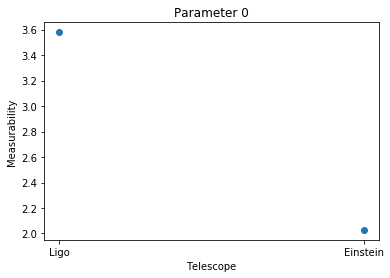

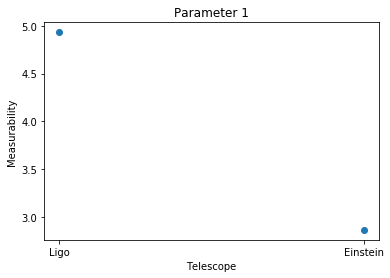

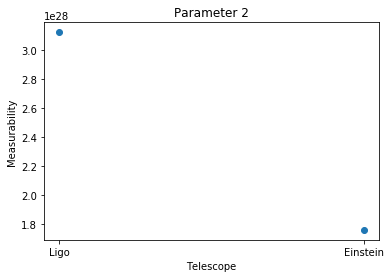

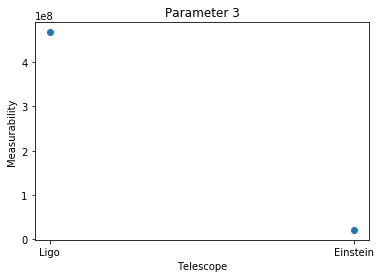

In [73]:
A1 = compute_A_2(fetch_ligo(6), 10)
fischer1 = generate_matrix_2(A1, teta, fetch_ligo(6))
results1 = extract_from_matrix(fischer1)
print("Ligo results for PN =", PN, " : " , results1 , "\n\n")


A2 = compute_A_2(fetch_einstein(3), 10)
fischer2 = generate_matrix_2(A2, teta, fetch_einstein(3))
results2 = extract_from_matrix(fischer2)
print("Einstein results for PN =", PN, " : " , results2)

print(comparison_plot(results1,results2))